In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! ln -s /content/drive/MyDrive/datasets/BreakHis_v1 /content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors/datasets

In [6]:
! ln -s /content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors/ /content

ln: failed to create symbolic link '/content/BreakHis_Activation-Map-Generation-Noised-Latent-Factors': File exists


In [7]:
%cd BreakHis_Activation-Map-Generation-Noised-Latent-Factors/

/content/drive/MyDrive/src/BreakHis_Activation-Map-Generation-Noised-Latent-Factors


In [4]:
! pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

# Initialization

In [8]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.15.1


In [15]:
from skimage.segmentation import slic
from skimage.exposure import rescale_intensity

In [9]:
import configs

In [ ]:
import importlib
importlib.reload(configs)
print(dir(configs))

['CGUNET_CHECKPOINT', 'CHECKPOINT_DIR', 'CLASSIFIER_CHECKPOINT', 'CLASS_NAMES', 'DATA_DIR', 'IMAGE_SIZE', 'NUM_CLASS', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [ ]:
import configs
from ActMapGen import *

# Data Loader

In [10]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_csv, subset,
                       batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.subsets_csv = subsets_csv
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.load()
        self.indices = None
        self.on_epoch_end()

    def load(self):
        df = pd.read_csv(self.subsets_csv)
        self.filenames = df[df['grp'] == self.subset
                            ]['filename'].tolist()
        self.filenames = [os.path.join(self.data_dir, it)
                          for it in self.filenames]
        print(len(self.filenames), 'images found')
        print(self.filenames[0])

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        X, Y = self.__data_generation(filenames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def filename2onehot(self, fn):
        for i, classname in enumerate(configs.CLASS_NAMES):
            if classname in fn:
                result = np.zeros(configs.NUM_CLASS, dtype=np.float64)
                result[i] = 1
                return result
        return None

    def __data_generation(self, filenames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y_class = np.empty([num, configs.NUM_CLASS])
        for i, fn in enumerate(filenames):
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
            img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y_class[i] = self.filename2onehot(fn)

        return X, {'out_img':X, 'out_class':Y_class}

In [11]:
train_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'train', shuffle=False)
val_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'val', shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.DATA_DIR+'/subsets.csv',
                                'test', shuffle=False)

4000 images found
datasets/BreakHis_v1/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-021.png
1000 images found
datasets/BreakHis_v1/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-003.png
2909 images found
datasets/BreakHis_v1/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-005.png


In [12]:
X, Y = train_datagen[0]

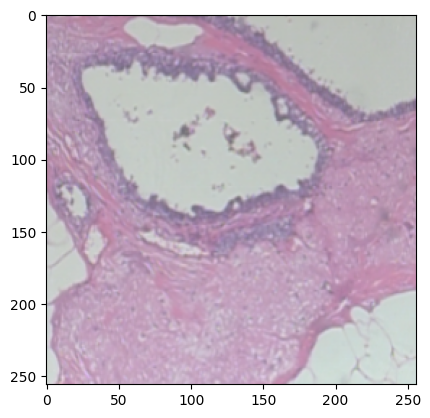

In [13]:
img = X[0]
plt.imshow((img*255).astype(np.uint8))

# Superpixel with SLIC

In [ ]:
# https://pyimagesearch.com/2017/06/26/labeling-superpixel-colorfulness-opencv-python/

In [14]:
def segment_colorfulness(image, mask):
	# split the image into its respective RGB components, then mask
	# each of the individual RGB channels so we can compute
	# statistics only for the masked region
	(R, G, B) = cv2.split(image.astype("float"))
	R = np.ma.masked_array(R, mask=mask)
	G = np.ma.masked_array(G, mask=mask)
	B = np.ma.masked_array(B, mask=mask)
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`,
	# then combine them
	stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
	meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [25]:
orig = (X[0]*255).astype(np.uint8)
vis = np.zeros(orig.shape[:2], dtype="float")

segments = slic(orig.astype(float), n_segments=128, slic_zero=True)

for v in np.unique(segments):
	mask = np.ones(orig.shape[:2])
	mask[segments == v] = 0
	C = segment_colorfulness(orig, mask)
	vis[segments == v] = C

In [26]:
vis = rescale_intensity(vis, out_range=(0, 255)).astype("uint8")
alpha = 0.4
overlay = np.dstack([vis] * 3)
output = orig.copy()
overlay = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)

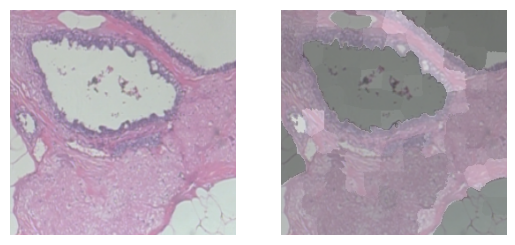

In [27]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow((img*255).astype(np.uint8))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(overlay)
plt.show()

In [20]:
np.unique(segments)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

In [21]:
def visualize_superpixels(orig, num_segments=128):
  vis = np.zeros(orig.shape[:2], dtype="float")
  segments = slic(orig.astype(float), n_segments=num_segments, slic_zero=True)

  for v in np.unique(segments):
    mask = np.ones(orig.shape[:2])
    mask[segments == v] = 0
    C = segment_colorfulness(orig, mask)
    vis[segments == v] = C

  vis = rescale_intensity(vis, out_range=(0, 255)).astype("uint8")
  alpha = 0.4
  overlay = np.dstack([vis] * 3)
  output = orig.copy()
  overlay = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)
  plt.imshow(overlay)
  return overlay

array([[[148, 136, 147],
        [161, 141, 159],
        [169, 150, 174],
        ...,
        [113, 116, 113],
        [112, 116, 111],
        [113, 117, 113]],

       [[158, 144, 154],
        [165, 145, 163],
        [159, 140, 160],
        ...,
        [113, 116, 113],
        [112, 116, 111],
        [113, 117, 113]],

       [[156, 141, 151],
        [157, 139, 154],
        [153, 133, 151],
        ...,
        [113, 116, 114],
        [113, 115, 111],
        [114, 117, 113]],

       ...,

       [[182, 186, 183],
        [184, 188, 185],
        [184, 188, 186],
        ...,
        [143, 150, 149],
        [142, 150, 149],
        [143, 150, 149]],

       [[183, 186, 185],
        [184, 187, 186],
        [185, 188, 187],
        ...,
        [143, 150, 149],
        [141, 150, 148],
        [141, 150, 148]],

       [[185, 188, 186],
        [186, 188, 187],
        [188, 188, 189],
        ...,
        [143, 152, 150],
        [142, 152, 149],
        [141, 150, 149]]], dtype=uint8)
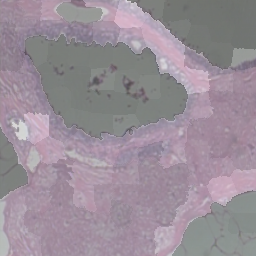

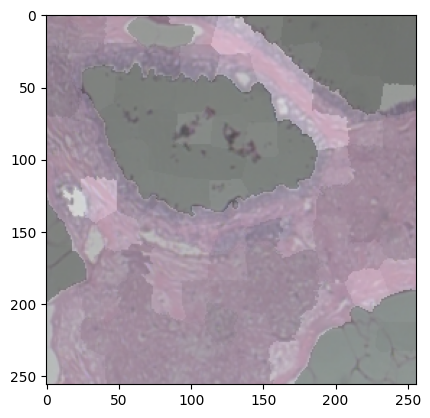

In [22]:
visualize_superpixels((X[0]*255.).astype(np.uint8))

# Activation Map Generation - Superpixel-wise

In [23]:
classifier = tf.keras.models.load_model(configs.CLASSIFIER_CHECKPOINT)

In [24]:
def compute_pixel_weights(img, gen_img):
  weights = np.sum(np.array(img - gen_img)**2, axis=2)
  weights /= np.max(weights)
  return weights

def confidence_diff(prediction_proba, prediction_proba_gen, label):
  return (prediction_proba[label] - prediction_proba_gen[label])**2

def random_toggle_superpixels(img, segments, i_segment):
  mask = np.ones(img.shape[:2])
  mask[segments == i_segment] = 0
  mask = np.dstack([mask] * 3)
  return mask * img

def generate_activation_map(img, label, classifier, num_segments=128):
  activation_map = np.zeros(img.shape[:2])
  prediction_proba = classifier.predict(np.array([img]), verbose=0)[0]

  segments = slic(img * 255., n_segments=num_segments, slic_zero=True)
  for i_segment in np.unique(segments):
    output_img = random_toggle_superpixels(img, segments, i_segment)

    px_weights = compute_pixel_weights(img, output_img)
    prediction_proba_gen = classifier.predict(np.array([output_img]), verbose=0)[0]
    activation_map += px_weights * confidence_diff(prediction_proba,
                                                   prediction_proba_gen,
                                                   label)
  return activation_map

(32, 256, 256, 3) (32, 8)


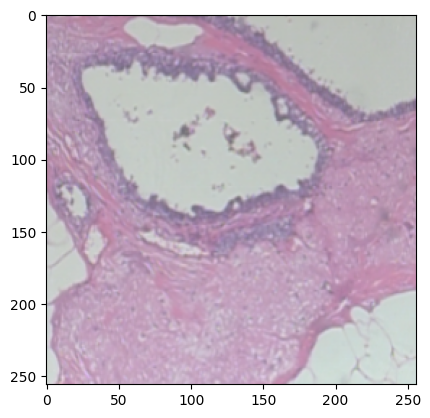

In [33]:
X, Ys = train_datagen[0]
Y = Ys['out_class']
print(X.shape, Y.shape)
plt.imshow((X[0]*255).astype(np.uint8))

# Generating

In [30]:
def run(index, num_segments=128):
  label = Y[index].argmax()
  print(index, label)
  img = X[index]
  vis = visualize_superpixels((img*255).astype(np.uint8))
  activation_map = generate_activation_map(img, label, classifier, num_segments)
  print(activation_map.shape)
  plt.subplot(1, 2, 1)
  plt.imshow(vis)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(activation_map)
  plt.axis('off')
  plt.show()

1 4
(256, 256)


<ipython-input-30-edf80a314eb8>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


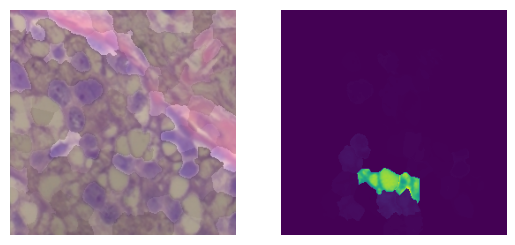

In [34]:
run(1, 128)

5 6
(256, 256)


<ipython-input-30-edf80a314eb8>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


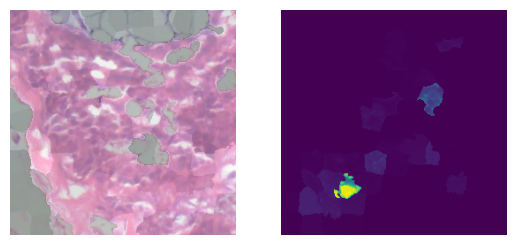

In [35]:
run(5, 128)

0 6
(256, 256)


<ipython-input-30-edf80a314eb8>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


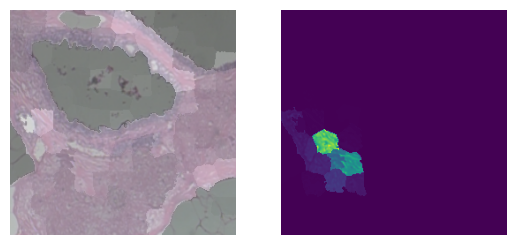

4 0
(256, 256)


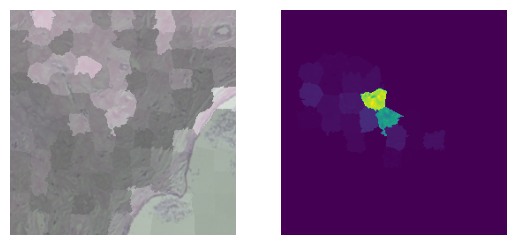

8 6
(256, 256)


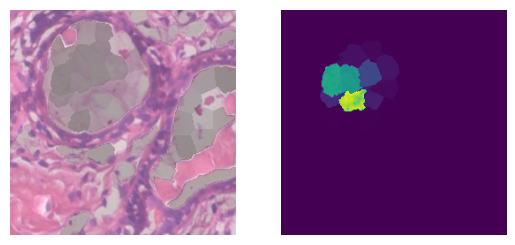

12 6
(256, 256)


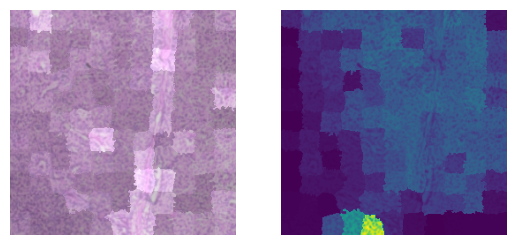

16 5
(256, 256)


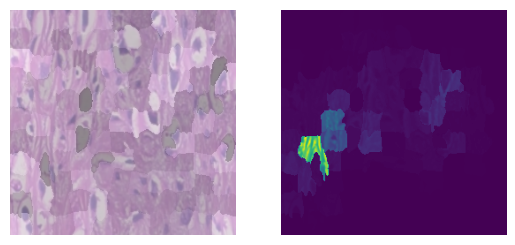

20 4
(256, 256)


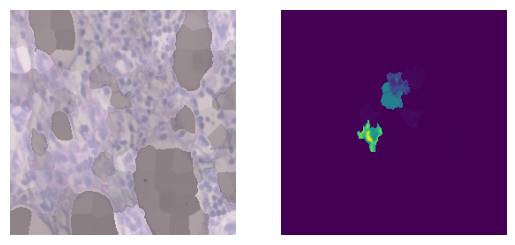

24 5
(256, 256)


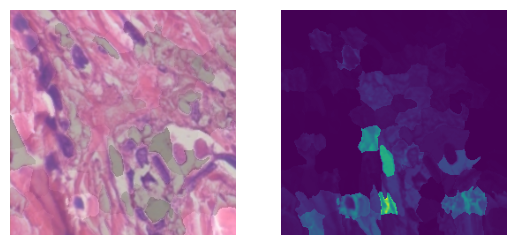

28 4
(256, 256)


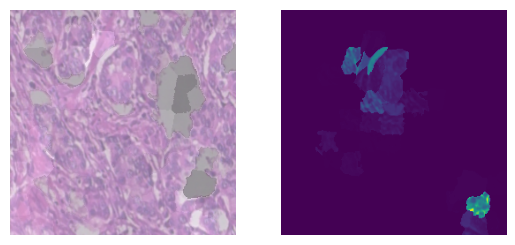

In [36]:
for i in range(0, 32, 4):
  run(i)